In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import scipy.stats as stats
import random
import numpy as np 

def compute_chi(data):
    '''
    Computes the value of Chi, a synchrony measurement that compares the variance of individual voltage traces and the variance of the mean of the voltages.

    Parameters:
        data (list[float]):
            Voltage traces with each row corresponding one neuron.

    Returns:
        chi (float):
            The value of Chi.
    '''

    #calculate the average voltage as a function of time
    mean_voltage = np.mean(data,axis=0)

    #calculate the variance of each trave and the average voltage
    ind_variance = np.mean(np.square(data),axis=1) - np.mean(data,axis=1)**2
    total_variance = np.mean(np.square(mean_voltage)) - np.mean(mean_voltage)**2

    #calculate chi
    chi = np.sqrt(total_variance**2 / np.mean(ind_variance**2))

    return chi 
import numpy as np 
from scipy.sparse import dok_matrix
import scipy as sp
from scipy import signal
def compute_Reliability(spike_matrix,t,t_R):
    '''
    Computes the value of Reliability, a synchrony measurement that computes the variance of a convoluted spike train that is the sum of the spike trains of each neuron.

    Parameters:
        spike_matrix (tuple[tuple[int,int]] | sparse_matrix):
            matrix containing spike trains, each row contains a diffent neuron.
        t (list[float]):
            time array, time points of the simulation
        t_R (float):
            Time constant

    Returns:
        reliability / reliability_max (float):
            The computed value of reliability, normalised so (theorically) is between 0 and 1.
        Convolved_matrix (tuple[float]):
            The convolved spike train.
    '''

    #compute the time step of the simulation
    T = t[-1] - t[0]
    dt = T / len(t)

    #we need to work with a np.ndarray for the convolution, if it is a sparse_matrix, change it to that type
    if type(spike_matrix) is not np.ndarray:
        spike_matrix = np.array(spike_matrix.todense())

    #Compute the mean number of spikes
    num_spikes = (spike_matrix>0).sum()/num_neurons

    #Compute the kernel, and convolve the sum spike train with it
    joined_matrix = np.sum(spike_matrix,axis=0)
    kernel = 1/ t_R *np.exp(-t / t_R)
    Convolved_matrix = signal.convolve(joined_matrix,kernel)[0:len(spike_matrix[0,:])]
    #Convolved_matrix = joined_matrix

    #compute the measurements of reliability
    reliability = 1 / t[len(t) - 1] * np.trapz(np.square(Convolved_matrix), dx = dt) - np.square( 1 / t[len(t) - 1] * np.trapz(Convolved_matrix,dx =dt))
    reliability_max = ( num_neurons**2 * num_spikes / ( t_R * 2 * T ) - ( num_neurons * num_spikes / T )**2 )
    #reliability_max = 1
    return reliability/reliability_max, Convolved_matrix

In [7]:
np.random.seed(101)

N = 300
T = 300
M = 50000
dt = 0.005
t0 = 0

k = 1
a = 0.1
b = 0.26
c = -65
d = -1
v_reset = c
v_thresh = 30

Esyn = -70
tauS = 3.043043043043043 # Obtained from having peaks of coupling in paper and in ours aligned

J = np.random.normal(0, 0.1, size=(N))


I = 0.33

# Define desired average number of connections
Avg_Connections = 40
connection_probability = Avg_Connections / N

# Initialize the synaptic coupling matrix
g = np.zeros((N, N))

# Sparsely connected networks with probabilistic connections
for j in range(N):
    for i in range(N):
        if i != j:  # Avoid self-connections
            if np.random.rand() < connection_probability:
                g[j, i] = 0.03  # Set connection strength 

# All-to-all connectivity
# g = np.random.uniform(0.05, 0.5, size=(N, N))
# np.fill_diagonal(g, 0)  # Set diagonal to zero to avoid self-connections



v_init = np.random.normal(-70, 5, size=(N))
u_init = np.random.normal(-15, 0.5, size = (N)) # Ask any reason why these were chosen and not ones in page 3 paper
s_init = np.zeros(N)
p_init = np.zeros(N)

t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init, s_init, p_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0

def dxdt(t, x, k, a, b, I, Esyn, J, tauS):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N:3*N]
    p = x[3*N:4*N]
    
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - (v - Esyn) * np.dot(g,s)
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    
    return np.concatenate([dvdt, dudt, dsdt, dpdt])

# Spike event
def v_spike(t, x, k, a, b, I, Esyn, J, tauS):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1

# Set up spike time vector
spike_times = np.zeros((M, 2))
spikeCounter = 0    
i = 0

Drive (I): 0.00, Average Firing Rate: 1.02 Hz
Drive (I): 0.10, Average Firing Rate: 2.42 Hz
Drive (I): 0.20, Average Firing Rate: 6.18 Hz
Drive (I): 0.30, Average Firing Rate: 9.70 Hz
Drive (I): 0.40, Average Firing Rate: 13.47 Hz
Drive (I): 0.50, Average Firing Rate: 15.95 Hz
Drive (I): 0.60, Average Firing Rate: 16.32 Hz
Drive (I): 0.70, Average Firing Rate: 19.77 Hz
Drive (I): 0.80, Average Firing Rate: 21.78 Hz
Drive (I): 0.90, Average Firing Rate: 25.43 Hz
Drive (I): 1.00, Average Firing Rate: 27.45 Hz


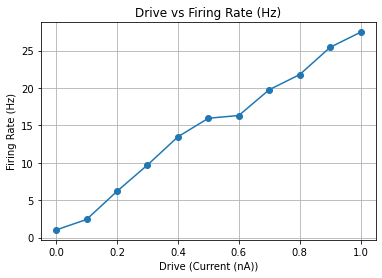

In [8]:
# Firing Rate
I_values = np.linspace(0, 1, 11)  # Array of driving currents
firing_rates = []  # To store computed firing rates

for I in I_values:  # Use each I as a scalar in this loop
    # Initial states
    v_init = np.random.normal(-70, 5, size=(N))
    u_init = np.random.normal(-15, 0.5, size=(N))
    s_init = np.zeros(N)
    p_init = np.zeros(N)

    t0 = 0
    spike_times = np.zeros((M, 2))  # Resets spike times array for each `I`
    spikeCounter = 0
    i = 0

    # Simulation loop
    while i < M and t0 < T:
        y0 = np.concatenate([v_init, u_init, s_init, p_init])  

        # Use solve_ivp for integration
        sol_v = solve_ivp(
            dxdt, [t0, T], y0, 
            args=(k, a, b, I, Esyn, J, tauS),  # Pass scalar `I`
            dense_output=True,
            events=v_spike,
            rtol=1e-8
        )
        
        t_end = sol_v.t[-1]
        t0 = t_end
        v_init = sol_v.y[:N, -1]
        u_init = sol_v.y[N:2*N, -1]
        s_init = sol_v.y[2*N:3*N, -1]
        p_init = sol_v.y[3*N:4*N, -1]

        if len(sol_v.t_events[0]) > 0:
            spike = v_init.argmax()
            v_init[spike] = v_reset
            u_init[spike] += d
            p_init[spike] += 2.7185823035951033

            spike_times[spikeCounter, :] = [t0, spike]
            spikeCounter += 1
            i += 1

    # Compute average firing rate for this I value
    average_firing_rate = len(spike_times[spike_times[:, 0] > 100]) / (N * (T - 100)) * 1000
    firing_rates.append(average_firing_rate)
    print(f"Drive (I): {I:.2f}, Average Firing Rate: {average_firing_rate:.2f} Hz")

# Plotting the results
plt.figure()
plt.plot(I_values, firing_rates, marker='o', linestyle='-')
plt.xlabel('Drive (Current (nA))')
plt.ylabel('Firing Rate (Hz)')
plt.title('Drive vs Firing Rate (Hz)')
plt.grid(True)
plt.show()


Drive (I): 0.00, Number of Neurons that Spiked: 25
Drive (I): 0.10, Number of Neurons that Spiked: 61
Drive (I): 0.20, Number of Neurons that Spiked: 141
Drive (I): 0.30, Number of Neurons that Spiked: 172
Drive (I): 0.40, Number of Neurons that Spiked: 207
Drive (I): 0.50, Number of Neurons that Spiked: 235
Drive (I): 0.60, Number of Neurons that Spiked: 242
Drive (I): 0.70, Number of Neurons that Spiked: 266
Drive (I): 0.80, Number of Neurons that Spiked: 272
Drive (I): 0.90, Number of Neurons that Spiked: 282
Drive (I): 1.00, Number of Neurons that Spiked: 277


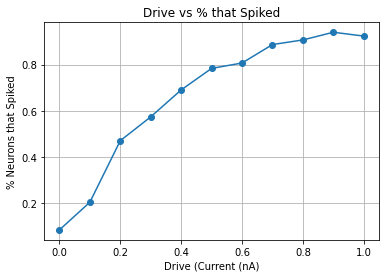

In [9]:
# % Neurons that spike
I_values = np.linspace(0, 1, 11)
no_neurons_spike = []
for I in I_values:
    
    

    # Initial states
    v_init = np.random.normal(-70, 5, size=(N))
    u_init = np.random.normal(-15, 0.5, size=(N))
    s_init = np.zeros(N)
    p_init = np.zeros(N)

    t0 = 0
    spike_times = []  # Track spike times as (time, neuron index)
    spikeCounter = 0
    i = 0

    # Simulation loop
    while i < M and t0 < T:
        y0 = np.concatenate([v_init, u_init, s_init, p_init])  
        
        sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                          events=v_spike, rtol=1e-8)
        
        t_end = sol_v.t[-1]
        t0 = t_end
        v_init = sol_v.y[:N, -1]
        u_init = sol_v.y[N:2*N, -1]
        s_init = sol_v.y[2*N:3*N, -1]
        p_init = sol_v.y[3*N:4*N, -1]

        if len(sol_v.t_events[0]) > 0:
            spike = v_init.argmax()
            v_init[spike] = v_reset
            u_init[spike] += d
            p_init[spike] += 2.7185823035951033

            spike_times.append((t0, spike))  # Record spike time and neuron index
            spikeCounter += 1
            i += 1

    # Determine the number of unique neurons that spiked
    spiking_neurons = len(set([neuron for _, neuron in spike_times]))
    no_neurons_spike.append(spiking_neurons)
    print(f"Drive (I): {I:.2f}, Number of Neurons that Spiked: {spiking_neurons}")

no_neurons_spike_array = np.array(no_neurons_spike)
fractional_spike = no_neurons_spike_array/N
plt.figure()
plt.plot(I_values, fractional_spike, marker='o', linestyle='-')
plt.xlabel('Drive (Current (nA)')
plt.ylabel('% Neurons that Spiked')
plt.title('Drive vs % that Spiked')
plt.grid(True)
plt.show()

Drive (I): 0.00, Chi: 0.06448799569159476
Drive (I): 0.10, Chi: 0.09798826624074511
Drive (I): 0.20, Chi: 0.17438345467555566
Drive (I): 0.30, Chi: 0.23393723679413483
Drive (I): 0.40, Chi: 0.2888451913909905
Drive (I): 0.50, Chi: 0.31266400383579485
Drive (I): 0.60, Chi: 0.33560608442168016
Drive (I): 0.70, Chi: 0.3576559111658768
Drive (I): 0.80, Chi: 0.3738566138222756
Drive (I): 0.90, Chi: 0.3754166311458529
Drive (I): 1.00, Chi: 0.3821690681216413


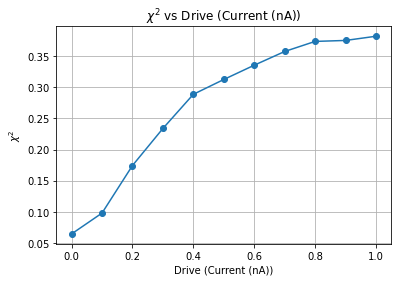

In [10]:
# Chi
I_values = np.linspace(0.0, 1.0, 11)  
chi_sq_values = []

for I in I_values:
    
    v_init = np.random.normal(-70, 5, size=(N))
    u_init = np.random.normal(-15, 0.5, size = (N))
    s_init = np.zeros(N)
    p_init = np.zeros(N)
    
    t_all = np.array([t0])
    y_0 = np.concatenate([v_init, u_init, s_init, p_init])
    y_all = np.reshape(y_0, (y_0.shape[0], 1))
    
    spike_times = np.zeros((M, 2))
    spikeCounter = 0
    i = 0
    t0 = 0  # Reset simulation start time

    # Simulation loop 
    while i < M and t0 < T:
        y0 = np.concatenate([v_init, u_init, s_init, p_init])  

        # Use solve_ivp 
        sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                          events=v_spike, rtol=1e-8)

        t_end = sol_v.t[-1]
        steps = max([2, int((t_end - t0) / dt)])
        t = np.linspace(t0, t_end, steps)
        y = sol_v.sol(t)
        
        t_all = np.concatenate([t_all, t[:-1]], axis=0)
        y_all = np.concatenate([y_all, y[:, :-1]], axis=1)

        t0 = t_end
        v_init = y[:N, -1]
        u_init = y[N:2*N, -1]
        s_init = y[2*N:3*N, -1]
        p_init = y[3*N:4*N, -1]

        if len(sol_v.t_events[0]) > 0:
            spike = v_init.argmax()
            v_init[spike] = v_reset
            u_init[spike] += d
            p_init[spike] += 2.7185823035951033
            
            spike_times[spikeCounter, :] = [t0, spike]
            spikeCounter += 1
            i += 1

    # Compute chi_sq 
    data = y_all[:N, :]
    chi_sq = compute_chi(data)
    chi_sq_values.append(chi_sq)
    print(f"Drive (I): {I:.2f}, Chi: {chi_sq}")

# Plotting the results
plt.figure()
plt.plot(I_values, chi_sq_values, marker='o', linestyle='-')
plt.xlabel('Drive (Current (nA))')
plt.ylabel(r'$\chi^2$')
plt.title(r'$\chi^2$ vs Drive (Current (nA))')
plt.grid(True)
plt.show()

Drive (I): 0.00, Reliability: 4.559633157002658e-15
Drive (I): 0.10, Reliability: 4.643298626023123e-15
Drive (I): 0.20, Reliability: 4.812009788869829e-15
Drive (I): 0.30, Reliability: 4.306962391545074e-15
Drive (I): 0.40, Reliability: 9.118035473550638e-15
Drive (I): 0.50, Reliability: 4.32819026491772e-15
Drive (I): 0.60, Reliability: 1.6307653746501645e-14
Drive (I): 0.70, Reliability: 4.232849837285371e-15
Drive (I): 0.80, Reliability: 4.396646308718425e-15
Drive (I): 0.90, Reliability: 2.498095246802626e-14
Drive (I): 1.00, Reliability: 4.1180195735417905e-15


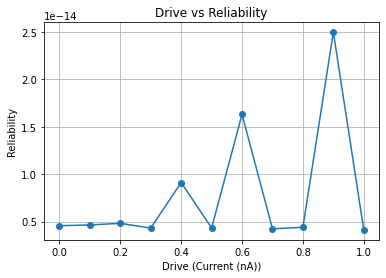

In [14]:
# Reliability
I_values = np.linspace(0.0, 1.0, 11)  
reliability_values = []
num_neurons = N
for I in I_values:
    
    v_init = np.random.normal(-70, 5, size=(N))
    u_init = np.random.normal(-15, 0.5, size=(N))
    s_init = np.zeros(N)
    p_init = np.zeros(N)

    t_all = np.array([t0])
    y_0 = np.concatenate([v_init, u_init, s_init, p_init])
    y_all = np.reshape(y_0, (y_0.shape[0], 1))

    spike_matrix = np.zeros((N, int(T / dt)))  # Initialize spike matrix
    spikeCounter = 0
    i = 0
    t0 = 0  

    while i < M and t0 < T:
        y0 = np.concatenate([v_init, u_init, s_init, p_init])  
        sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                          events=v_spike, rtol=1e-8)

        t_end = sol_v.t[-1]
        steps = max([2, int((t_end - t0) / dt)])
        t = np.linspace(t0, t_end, steps)
        y = sol_v.sol(t)
        
        t_all = np.concatenate([t_all, t[:-1]], axis=0)
        y_all = np.concatenate([y_all, y[:, :-1]], axis=1)

        t0 = t_end
        v_init = y[:N, -1]
        u_init = y[N:2*N, -1]
        s_init = y[2*N:3*N, -1]
        p_init = y[3*N:4*N, -1]

        # Log spikes in spike_matrix
        if len(sol_v.t_events[0]) > 0:
            spike = v_init.argmax()
            v_init[spike] = v_reset
            u_init[spike] += d
            p_init[spike] += 2.7185823035951033

            spike_idx = int(t0 / dt)
            spike_matrix[spike, spike_idx] = 1
            spikeCounter += 1
            i += 1

    # Compute reliability
    reliability, _ = compute_Reliability(spike_matrix, t_all, t_R=29.29)
    #reliability, _ = compute_Reliability(spike_matrix, t_all, tauS)
    reliability_values.append(reliability)
    print(f"Drive (I): {I:.2f}, Reliability: {reliability}")

# Plotting the results
plt.figure()
plt.plot(I_values, reliability_values, marker='o', linestyle='-')
plt.xlabel('Drive (Current (nA))')
plt.ylabel('Reliability')
plt.title('Drive vs Reliability')
plt.grid(True)
plt.show()
